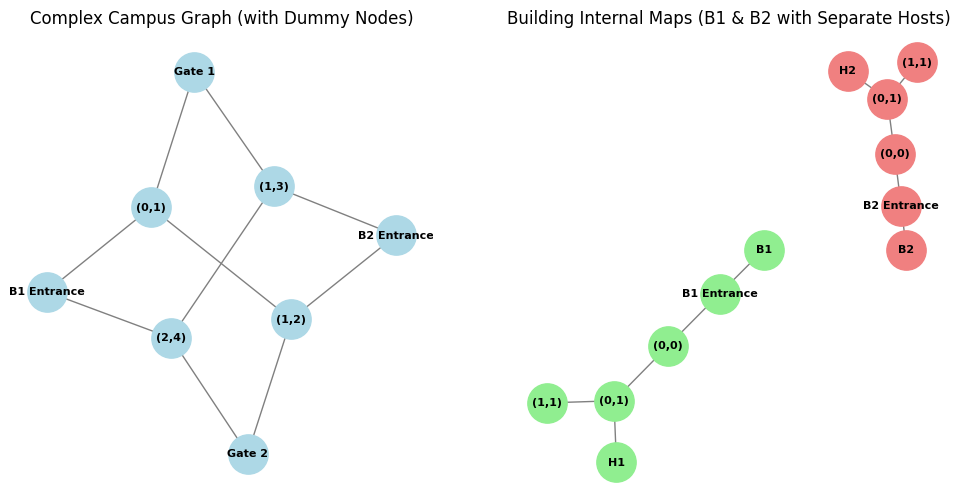

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Define a more complex campus graph (CI agent navigation)
campus_graph = nx.Graph()

# Nodes for campus: Gates, Buildings, and Dummy nodes (labeled as coordinates)
campus_graph.add_nodes_from(['Gate 1', 'Gate 2', 'B1 Entrance', 'B2 Entrance',
                             '(0,1)', '(1,2)', '(1,3)', '(2,4)'])

# Edges for campus (connecting gates, dummy nodes, and building entrances)
campus_graph.add_edges_from([
    ('Gate 1', '(0,1)'), ('Gate 1', '(1,3)'),
    ('(0,1)', '(1,2)'), ('(0,1)', 'B1 Entrance'),
    ('(1,2)', 'B2 Entrance'), ('Gate 2', '(1,2)'),
    ('(1,3)', '(2,4)'), ('(2,4)', 'B1 Entrance'),
    ('Gate 2', '(2,4)'), ('(1,3)', 'B2 Entrance')
])

# Step 2: Define internal building maps (BI agent navigation)
# Building 1 internal map with coordinates instead of room names, separate 'B1' and 'H1'
B1_graph = nx.Graph()
B1_graph.add_nodes_from(['B1 Entrance', '(0,0)', '(0,1)', '(1,1)', 'H1', 'B1'])  # 'H1' and 'B1' are separate
B1_graph.add_edges_from([('B1 Entrance', '(0,0)'),
                         ('(0,0)', '(0,1)'),
                         ('(0,1)', '(1,1)'),
                         ('B1 Entrance', 'B1'),
                         ('(0,1)', 'H1')])

# Building 2 internal map with coordinates instead of room names, separate 'B2' and 'H2'
B2_graph = nx.Graph()
B2_graph.add_nodes_from(['B2 Entrance', '(0,0)', '(0,1)', '(1,1)', 'H2', 'B2'])  # 'H2' and 'B2' are separate
B2_graph.add_edges_from([('B2 Entrance', '(0,0)'),
                         ('(0,0)', '(0,1)'),
                         ('(0,1)', '(1,1)'),
                         ('B2 Entrance', 'B2'),
                         ('(0,1)', 'H2')])

# Step 3: Visualize the campus graph and internal building maps
plt.figure(figsize=(12, 6))

# Plot the campus graph with smaller node size and dummy labels as coordinates
plt.subplot(1, 2, 1)
nx.draw(campus_graph, with_labels=True, node_color='lightblue', node_size=800, font_size=8, font_weight='bold', edge_color='gray')
plt.title("Complex Campus Graph (with Dummy Nodes)")

# Plot the internal maps of Building 1 and Building 2
plt.subplot(1, 2, 2)
pos_B1 = nx.spring_layout(B1_graph)
pos_B2 = nx.spring_layout(B2_graph, center=(2,2))  # To shift the second graph

# Plot Building 1 with fixed hosts (B1 and H1 in separate nodes)
nx.draw(B1_graph, pos=pos_B1, with_labels=True, node_color='lightgreen', node_size=800, font_size=8, font_weight='bold', edge_color='gray')
# Plot Building 2 with fixed hosts (B2 and H2 in separate nodes)
nx.draw(B2_graph, pos=pos_B2, with_labels=True, node_color='lightcoral', node_size=800, font_size=8, font_weight='bold', edge_color='gray')

plt.title("Building Internal Maps (B1 & B2 with Separate Hosts)")
plt.show()


In [ ]:
import random
import time
import queue

class Visitor:
    """Visitor agent class that contains visitor details."""
    def __init__(self, visitor_id, host, building):
        self.visitor_id = visitor_id
        self.host = host
        self.building = building
        self.meeting_duration = random.randint(5, 30)  # Random meeting duration

class CIAgent:
    """Campus Incharge Agent that guides the visitor to the building."""
    def __init__(self, ci_id):
        self.ci_id = ci_id
        self.visitors_entertained = 0
        self.penalties = 0  # For violations such as delays

    def guide_visitor(self, visitor):
        print(f"CI Agent {self.ci_id} is guiding {visitor.visitor_id} to {visitor.building} for host {visitor.host}")
        self.visitors_entertained += 1
        return self.request_navigation_from_bi(visitor)

    def request_navigation_from_bi(self, visitor):
        """Sends a request to the BI agent for the navigation path."""
        ci_message = {
            "type": "CI Request",
            "visitor_id": visitor.visitor_id,
            "assigned_host": visitor.host,
            "building": visitor.building
        }
        print(f"CI Agent {self.ci_id} requesting navigation from BI agent: {ci_message}")
        return ci_message

class BIAgent:
    """Building Incharge Agent that provides building navigation and manages out of service state."""
    def __init__(self, bi_id, building):
        self.bi_id = bi_id
        self.building = building
        self.oos_duration = 0
        self.in_service = True
        self.guided_visitors = 0
        self.penalties = 0

    def provide_navigation(self, ci_message):
        """Handles navigation requests from CI agents."""
        if not self.in_service:
            return self.deny_access(ci_message)

        if ci_message["assigned_host"] == self.bi_id:
            self.go_out_of_service()
            print(f"BI Agent {self.bi_id} is hosting {ci_message['visitor_id']}")
            return {"type": "BI Response", "response": "Hosting", "visitor_id": ci_message["visitor_id"], "oos_duration": self.oos_duration}

        print(f"BI Agent {self.bi_id} providing path to {ci_message['assigned_host']} in {self.building}")
        self.guided_visitors += 1
        return {"type": "BI Response", "response": "Approved", "navigation_path": f"Path to {ci_message['assigned_host']} in {self.building}"}

    def deny_access(self, ci_message):
        """Denies access when BI agent is out of service."""
        return {"type": "BI Response", "response": "Denied", "reason": "BI Agent out of service", "oos_duration": self.oos_duration}

    def go_out_of_service(self):
        """Marks BI agent as out of service while hosting a visitor."""
        self.in_service = False
        self.oos_duration = random.randint(5, 20)  # Random out of service duration
        print(f"BI Agent {self.bi_id} is out of service for {self.oos_duration} minutes")
        time.sleep(self.oos_duration / 10)  # Simulating the out of service time (scaled down for the simulation)
        self.in_service = True
        print(f"BI Agent {self.bi_id} is back in service")

    def check_oos_violation(self, actual_time):
        """Checks if the OOS duration was exceeded."""
        if actual_time > self.oos_duration:
            print(f"Violation! BI Agent {self.bi_id} exceeded the OOS time by {actual_time - self.oos_duration} minutes")
            self.penalties += 1

# Visitor Factory that randomly creates visitors and assigns hosts
class VisitorFactory:
    def __init__(self):
        self.visitor_count = 0

    def create_visitor(self):
        self.visitor_count += 1
        visitor_id = f"Visitor_{self.visitor_count}"

        # Randomly assign host and building
        building = random.choice(["Building 1", "Building 2"])
        if building == "Building 1":
            host = random.choice(["B1", "H1"])
        else:
            host = random.choice(["B2", "H2"])

        return Visitor(visitor_id, host, building)

# Performance metrics
class PerformanceMetrics:
    def __init__(self, agents):
        self.agents = agents

    def print_metrics(self):
        for agent in self.agents:
            if isinstance(agent, CIAgent):
                print(f"CI Agent {agent.ci_id}: Visitors entertained = {agent.visitors_entertained}, Penalties = {agent.penalties}")
            elif isinstance(agent, BIAgent):
                print(f"BI Agent {agent.bi_id}: Visitors guided = {agent.guided_visitors}, Penalties = {agent.penalties}")

# Simulate the entire process
def simulate():
    visitor_factory = VisitorFactory()
    ci_agent = CIAgent("CI_1")
    bi_agent_b1 = BIAgent("BI_1", "Building 1")
    bi_agent_b2 = BIAgent("BI_2", "Building 2")

    agents = [ci_agent, bi_agent_b1, bi_agent_b2]

    for _ in range(5):  # Simulate 5 visitors
        visitor = visitor_factory.create_visitor()

        # CI agent guides visitor to the building and requests BI navigation
        ci_message = ci_agent.guide_visitor(visitor)

        # BI agent responds to the CI agent's request
        if visitor.building == "Building 1":
            bi_response = bi_agent_b1.provide_navigation(ci_message)
            if bi_response["response"] == "Hosting":
                bi_agent_b1.check_oos_violation(visitor.meeting_duration)
        else:
            bi_response = bi_agent_b2.provide_navigation(ci_message)
            if bi_response["response"] == "Hosting":
                bi_agent_b2.check_oos_violation(visitor.meeting_duration)

        print(f"BI Agent Response: {bi_response}")
        print(f"Visitor {visitor.visitor_id} will meet {visitor.host} for {visitor.meeting_duration} minutes.\n")

    # Print performance metrics
    metrics = PerformanceMetrics(agents)
    metrics.print_metrics()

# Run the simulation
simulate()


CI Agent CI_1 is guiding Visitor_1 to Building 2 for host B2
CI Agent CI_1 requesting navigation from BI agent: {'type': 'CI Request', 'visitor_id': 'Visitor_1', 'assigned_host': 'B2', 'building': 'Building 2'}
BI Agent BI_2 providing path to B2 in Building 2
BI Agent Response: {'type': 'BI Response', 'response': 'Approved', 'navigation_path': 'Path to B2 in Building 2'}
Visitor Visitor_1 will meet B2 for 20 minutes.

CI Agent CI_1 is guiding Visitor_2 to Building 1 for host B1
CI Agent CI_1 requesting navigation from BI agent: {'type': 'CI Request', 'visitor_id': 'Visitor_2', 'assigned_host': 'B1', 'building': 'Building 1'}
BI Agent BI_1 providing path to B1 in Building 1
BI Agent Response: {'type': 'BI Response', 'response': 'Approved', 'navigation_path': 'Path to B1 in Building 1'}
Visitor Visitor_2 will meet B1 for 22 minutes.

CI Agent CI_1 is guiding Visitor_3 to Building 2 for host B2
CI Agent CI_1 requesting navigation from BI agent: {'type': 'CI Request', 'visitor_id': 'Visito

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
import random

# Define CI and BI agents and Visitor
class Visitor:
    """Visitor agent class."""
    def __init__(self, visitor_id, host, building):
        self.visitor_id = visitor_id
        self.host = host
        self.building = building

class CIAgent:
    """CI agent that guides the visitor to the building."""
    def __init__(self, ci_id):
        self.ci_id = ci_id
        self.visitors_entertained = 0

    def guide_visitor(self, visitor, campus_graph):
        self.visitors_entertained += 1
        print(f"CI Agent {self.ci_id} is guiding {visitor.visitor_id} to {visitor.building}")

        # Find the shortest path from Gate to the assigned host, including dummy nodes
        if visitor.building == "Building 1":
            start = 'Gate 1'
        else:
            start = 'Gate 2'
        end = visitor.host
        shortest_path = nx.dijkstra_path(campus_graph, source=start, target=end, weight='weight')
        return shortest_path

# Create CI and BI agents and a visitor factory
ci_agent = CIAgent("CI_1")

# Visualization graph (Campus Map with Dummy Nodes)
campus_graph = nx.Graph()

# Add nodes for Campus, Buildings, Dummy nodes, and Hosts
campus_graph.add_nodes_from(['Gate 1', 'Gate 2', 'B1 Entrance', 'B2 Entrance',
                             '(0,1)', '(1,2)', '(1,3)', '(2,4)', 'H1', 'B1', 'H2', 'B2'])

# Add edges representing the paths with weights (distances)
campus_graph.add_weighted_edges_from([('Gate 1', '(0,1)', 3), ('Gate 1', '(1,3)', 4),
                                      ('(0,1)', 'B1 Entrance', 2), ('(0,1)', '(1,2)', 3),
                                      ('Gate 2', '(1,2)', 3), ('Gate 2', '(2,4)', 4),
                                      ('(1,2)', 'B2 Entrance', 2), ('(1,3)', 'B2 Entrance', 2),
                                      ('B1 Entrance', 'B1', 1), ('B1 Entrance', 'H1', 1),
                                      ('B2 Entrance', 'B2', 1), ('B2 Entrance', 'H2', 1)])

# Define the visitor factory
def create_visitor(visitor_id):
    host = random.choice(['H1', 'H2', 'B1', 'B2'])
    building = "Building 1" if host in ['H1', 'B1'] else "Building 2"
    return Visitor(visitor_id, host, building)

# Simulation data
visitors = []
visitor_paths = {}  # Store visitor paths and their current positions
positions = nx.spring_layout(campus_graph)  # Layout positions for the nodes

# Function to move the visitor step by step
def move_along_path(visitor_id, path, step):
    if step < len(path) - 1:
        return path[step], path[step + 1]  # Return the current and next node
    return path[-1], None  # Return the last node when at the end of the path

# Linear interpolation to move a dot between two points
def interpolate(p1, p2, t):
    x = p1[0] + (p2[0] - p1[0]) * t
    y = p1[1] + (p2[1] - p1[1]) * t
    return [x, y]

# Visualization function (called every frame)
def update(frame):
    plt.clf()  # Clear the current plot

    # Draw the campus map with dummy nodes
    nx.draw(campus_graph, pos=positions, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)

    # Randomly create a new visitor and assign CI agent
    if random.random() > 0.7 and len(visitors) < 5:
        visitor_id = len(visitors) + 1
        visitor = create_visitor(f"Visitor_{visitor_id}")
        visitors.append(visitor)
        visitor_paths[visitor.visitor_id] = {
            "path": ci_agent.guide_visitor(visitor, campus_graph),
            "step": 0,
            "t": 0.0
        }
        print(f"New visitor: {visitor.visitor_id}, Assigned host: {visitor.host}")

    # Update visitor movements step by step
    for visitor in visitors:
        path_data = visitor_paths[visitor.visitor_id]
        path = path_data["path"]
        step = path_data["step"]
        t = path_data["t"]

        # Move visitor to the next step on the path
        current_node, next_node = move_along_path(visitor.visitor_id, path, step)
        if next_node is not None:
            # Get the positions of the current and next node
            p1 = positions[current_node]
            p2 = positions[next_node]

            # Interpolate the position of the dot between the current and next node
            dot_position = interpolate(p1, p2, t)
            plt.scatter(dot_position[0], dot_position[1], color='red', s=100)  # Draw the moving dot

            # Update 't' for smooth transition between nodes
            t += 0.1
            if t >= 1.0:  # If 't' exceeds 1, move to the next step
                path_data["step"] += 1
                path_data["t"] = 0.0  # Reset 't' for the next transition
            else:
                path_data["t"] = t

            # Highlight the edge representing the movement
            nx.draw_networkx_edges(campus_graph, pos=positions, edgelist=[(current_node, next_node)], edge_color='green', width=2)
        else:
            # Mark the visitor at the host (final position)
            nx.draw_networkx_nodes(campus_graph, pos=positions, nodelist=[path[-1]], node_color='red', node_size=2000)
            print(f"Visitor {visitor.visitor_id} has reached {path[-1]}")

# Create and run the animation
fig = plt.figure(figsize=(10, 6))
ani = FuncAnimation(fig, update, frames=100, interval=200, repeat=True)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
import random

# Define CI and BI agents and Visitor
class Visitor:
    """Visitor agent class."""
    def __init__(self, visitor_id, host, building, priority):
        self.visitor_id = visitor_id
        self.host = host
        self.building = building
        self.priority = priority  # Priority level of the visitor

class CIAgent:
    """CI agent that guides the visitor to the building."""
    def __init__(self, ci_id):
        self.ci_id = ci_id
        self.visitors_entertained = 0

    def guide_visitor(self, visitor, campus_graph, bi_agents):
        self.visitors_entertained += 1
        print(f"CI Agent {self.ci_id} is guiding {visitor.visitor_id} to {visitor.building}")

        # Find the shortest path from Gate to the assigned host, including dummy nodes
        if visitor.building == "Building 1":
            start = 'Gate 1'
            bi_agent = bi_agents['BI_1']  # Assign BI agent for Building 1
        else:
            start = 'Gate 2'
            bi_agent = bi_agents['BI_2']  # Assign BI agent for Building 2

        # CI requests navigation from BI agent
        response = bi_agent.provide_navigation(visitor)

        if response['response'] == 'Approved':
            shortest_path = nx.dijkstra_path(campus_graph, source=start, target=visitor.host, weight='weight')
            return shortest_path
        else:
            print(f"Navigation denied for {visitor.visitor_id}: {response['reason']}")
            return None

class BIAgent:
    """BI agent responsible for building navigation."""
    def __init__(self, bi_id, building):
        self.bi_id = bi_id
        self.building = building
        self.in_service = True  # Initially in service
        self.oos_duration = 0

    def provide_navigation(self, visitor):
        """BI agent responds to CI agent with navigation instructions or denial."""
        if not self.in_service:
            return {"response": "Denied", "reason": "BI Agent out of service"}
        else:
            print(f"BI Agent {self.bi_id} approved navigation to {visitor.host} for {visitor.visitor_id}")
            return {"response": "Approved"}

# Create CI and BI agents and a visitor factory
ci_agent_1 = CIAgent("CI_1")
ci_agent_2 = CIAgent("CI_2")
bi_agent_b1 = BIAgent("BI_1", "Building 1")
bi_agent_b2 = BIAgent("BI_2", "Building 2")

bi_agents = {
    "BI_1": bi_agent_b1,
    "BI_2": bi_agent_b2
}

# Visualization graph (Campus Map with Dummy Nodes)
campus_graph = nx.Graph()

# Add nodes for Campus, Buildings, Dummy nodes, and Hosts
campus_graph.add_nodes_from(['Gate 1', 'Gate 2', 'B1 Entrance', 'B2 Entrance',
                             '(0,1)', '(1,2)', '(1,3)', '(2,4)', 'H1', 'B1', 'H2', 'B2'])

# Add edges representing the paths with weights (distances)
campus_graph.add_weighted_edges_from([('Gate 1', '(0,1)', 3), ('Gate 1', '(1,3)', 4),
                                      ('(0,1)', 'B1 Entrance', 2), ('(0,1)', '(1,2)', 3),
                                      ('Gate 2', '(1,2)', 3), ('Gate 2', '(2,4)', 4),
                                      ('(1,2)', 'B2 Entrance', 2), ('(1,3)', 'B2 Entrance', 2),
                                      ('B1 Entrance', 'B1', 1), ('B1 Entrance', 'H1', 1),
                                      ('B2 Entrance', 'B2', 1), ('B2 Entrance', 'H2', 1)])

# Define the visitor factory
def create_visitor(visitor_id):
    host = random.choice(['H1', 'H2', 'B1', 'B2'])
    building = "Building 1" if host in ['H1', 'B1'] else "Building 2"
    priority = random.randint(1, 10)  # Random priority assigned to visitors
    return Visitor(visitor_id, host, building, priority)

# Simulation data
visitors = []
visitor_paths = {}  # Store visitor paths and their current positions
positions = nx.spring_layout(campus_graph)  # Layout positions for the nodes

# Function to move the visitor step by step
def move_along_path(visitor_id, path, step):
    if step < len(path) - 1:
        return path[step], path[step + 1]  # Return the current and next node
    return path[-1], None  # Return the last node when at the end of the path

# Linear interpolation to move a dot between two points
def interpolate(p1, p2, t):
    x = p1[0] + (p2[0] - p1[0]) * t
    y = p1[1] + (p2[1] - p1[1]) * t
    return [x, y]

# Visualization function (called every frame)
def update(frame):
    plt.clf()  # Clear the current plot

    # Draw the campus map with dummy nodes
    nx.draw(campus_graph, pos=positions, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)

    # Randomly create a new visitor and assign CI agent
    if random.random() > 0.7 and len(visitors) < 5:
        visitor_id = len(visitors) + 1
        visitor = create_visitor(f"Visitor_{visitor_id}")
        visitors.append(visitor)
        visitor_paths[visitor.visitor_id] = {
            "path": ci_agent_1.guide_visitor(visitor, campus_graph, bi_agents),
            "step": 0,
            "t": 0.0
        }
        print(f"New visitor: {visitor.visitor_id}, Assigned host: {visitor.host}, Priority: {visitor.priority}")

    # Update visitor movements step by step
    for visitor in visitors:
        path_data = visitor_paths[visitor.visitor_id]
        path = path_data["path"]
        if path:
            step = path_data["step"]
            t = path_data["t"]

            # Move visitor to the next step on the path
            current_node, next_node = move_along_path(visitor.visitor_id, path, step)
            if next_node is not None:
                # Get the positions of the current and next node
                p1 = positions[current_node]
                p2 = positions[next_node]

                # Interpolate the position of the dot between the current and next node
                dot_position = interpolate(p1, p2, t)
                plt.scatter(dot_position[0], dot_position[1], color='red', s=100)  # Draw the moving dot

                # Update 't' for smooth transition between nodes
                t += 0.1
                if t >= 1.0:  # If 't' exceeds 1, move to the next step
                    path_data["step"] += 1
                    path_data["t"] = 0.0  # Reset 't' for the next transition
                else:
                    path_data["t"] = t

                # Highlight the edge representing the movement
                nx.draw_networkx_edges(campus_graph, pos=positions, edgelist=[(current_node, next_node)], edge_color='green', width=2)
            else:
                # Mark the visitor at the host (final position)
                nx.draw_networkx_nodes(campus_graph, pos=positions, nodelist=[path[-1]], node_color='red', node_size=2000)
                print(f"Visitor {visitor.visitor_id} has reached {path[-1]}")

# Create and run the animation
fig = plt.figure(figsize=(10, 6))
ani = FuncAnimation(fig, update, frames=100, interval=200, repeat=True)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
import random

# Define Visitor Agent
class Visitor:
    def __init__(self, visitor_id, host, building, priority):
        self.visitor_id = visitor_id
        self.host = host
        self.building = building
        self.priority = priority  # Priority level of the visitor

# Define CI Agent
class CIAgent:
    """CI agent responsible for guiding visitors."""
    def __init__(self, ci_id):
        self.ci_id = ci_id
        self.visitors_entertained = 0
        self.current_load = 0  # Number of visitors the agent is handling
        self.max_load = 3  # Max number of visitors the agent can handle

    def guide_visitor(self, visitor, campus_graph, bi_agents):
        if self.current_load >= self.max_load:
            print(f"CI Agent {self.ci_id} is overloaded!")
            return None

        self.visitors_entertained += 1
        self.current_load += 1  # Increment the load

        print(f"CI Agent {self.ci_id} is guiding {visitor.visitor_id} (Priority: {visitor.priority}) to {visitor.building}")

        # Find the shortest path from the gate to the host's location
        if visitor.building == "Building 1":
            start = 'Gate 1'
            bi_agent = bi_agents['BI_1']
        else:
            start = 'Gate 2'
            bi_agent = bi_agents['BI_2']

        # Request navigation from BI agent
        response = bi_agent.provide_navigation(visitor)

        if response['response'] == 'Approved':
            shortest_path = nx.dijkstra_path(campus_graph, source=start, target=visitor.host, weight='weight')
            return shortest_path
        else:
            print(f"Navigation denied for {visitor.visitor_id}: {response['reason']}")
            return None

    def release_visitor(self):
        """Called when a visitor is successfully guided."""
        self.current_load -= 1

# Define BI Agent with Out-of-Service (OOS) capability
class BIAgent:
    def __init__(self, bi_id, building):
        self.bi_id = bi_id
        self.building = building
        self.in_service = True  # Initially in service
        self.oos_duration = 0

    def provide_navigation(self, visitor):
        """BI agent responds to CI agent with navigation instructions or denial."""
        if not self.in_service:
            return {"response": "Denied", "reason": "BI Agent out of service"}
        else:
            print(f"BI Agent {self.bi_id} approved navigation to {visitor.host} for {visitor.visitor_id}")
            return {"response": "Approved"}

    def go_oos(self, duration):
        """Simulate the BI agent going out of service for a specific duration."""
        self.in_service = False
        self.oos_duration = duration
        print(f"BI Agent {self.bi_id} is out of service for {duration} frames.")

    def update_oos(self):
        """Update the OOS status of the BI agent each frame."""
        if self.oos_duration > 0:
            self.oos_duration -= 1
        if self.oos_duration == 0 and not self.in_service:
            self.in_service = True
            print(f"BI Agent {self.bi_id} is back in service.")

# Create CI and BI agents
ci_agent_1 = CIAgent("CI_1")
ci_agent_2 = CIAgent("CI_2")
bi_agent_b1 = BIAgent("BI_1", "Building 1")
bi_agent_b2 = BIAgent("BI_2", "Building 2")

bi_agents = {"BI_1": bi_agent_b1, "BI_2": bi_agent_b2}

# Define the visitor factory
def create_visitor(visitor_id):
    host = random.choice(['H1', 'H2', 'B1', 'B2'])
    building = "Building 1" if host in ['H1', 'B1'] else "Building 2"
    priority = random.randint(1, 10)
    return Visitor(visitor_id, host, building, priority)

# Define the Campus Graph
campus_graph = nx.Graph()
campus_graph.add_nodes_from(['Gate 1', 'Gate 2', 'B1 Entrance', 'B2 Entrance',
                             '(0,1)', '(1,2)', '(1,3)', '(2,4)', 'H1', 'B1', 'H2', 'B2'])
campus_graph.add_weighted_edges_from([('Gate 1', '(0,1)', 3), ('Gate 1', '(1,3)', 4),
                                      ('(0,1)', 'B1 Entrance', 2), ('(0,1)', '(1,2)', 3),
                                      ('Gate 2', '(1,2)', 3), ('Gate 2', '(2,4)', 4),
                                      ('(1,2)', 'B2 Entrance', 2), ('(1,3)', 'B2 Entrance', 2),
                                      ('B1 Entrance', 'B1', 1), ('B1 Entrance', 'H1', 1),
                                      ('B2 Entrance', 'B2', 1), ('B2 Entrance', 'H2', 1)])

# Simulation data
visitors = []
visitor_paths = {}
positions = nx.spring_layout(campus_graph)  # Layout positions for the nodes

# BI Agent OOS Simulation
def bi_agent_oos_simulation(frame):
    if frame % 50 == 0:  # Randomly take BI agents out of service
        bi_agent = random.choice([bi_agent_b1, bi_agent_b2])
        bi_agent.go_oos(duration=random.randint(5, 15))

    # Update OOS status for all BI agents
    bi_agent_b1.update_oos()
    bi_agent_b2.update_oos()

# Visualization update
def update(frame):
    plt.clf()  # Clear the current plot

    # Simulate BI Agent OOS
    bi_agent_oos_simulation(frame)

    # Draw the campus map
    nx.draw(campus_graph, pos=positions, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)

    # Randomly create new visitors and assign CI agents based on availability and load
    if random.random() > 0.7 and len(visitors) < 5:
        visitor_id = len(visitors) + 1
        visitor = create_visitor(f"Visitor_{visitor_id}")
        visitors.append(visitor)
        print(f"New visitor: {visitor.visitor_id}, Priority: {visitor.priority}")

        # Assign the visitor to the CI agent with the lowest load
        if ci_agent_1.current_load < ci_agent_2.current_load:
            path = ci_agent_1.guide_visitor(visitor, campus_graph, bi_agents)
        else:
            path = ci_agent_2.guide_visitor(visitor, campus_graph, bi_agents)

        if path:
            visitor_paths[visitor.visitor_id] = {"path": path, "step": 0, "t": 0.0}

    # Update visitor movements along their paths
    for visitor in visitors:
        if visitor.visitor_id in visitor_paths:
            path_data = visitor_paths[visitor.visitor_id]
            path = path_data["path"]
            step = path_data["step"]
            t = path_data["t"]

            # Ensure we stop once visitor reaches the final node
            if step < len(path) - 1:
                # Move visitor along the path step by step
                current_node, next_node = path[step], path[step + 1]

                # Get positions of current and next node
                p1 = positions[current_node]
                p2 = positions[next_node]

                # Interpolate the visitor's position between nodes
                dot_position = [p1[0] + (p2[0] - p1[0]) * t, p1[1] + (p2[1] - p1[1]) * t]
                plt.scatter(dot_position[0], dot_position[1], color='red', s=100)

                # Update 't' for smooth transition between nodes
                t += 0.05  # Control movement speed here
                if t >= 1.0:
                    path_data["step"] += 1
                    path_data["t"] = 0.0
                else:
                    path_data["t"] = t

                # Highlight the edge between nodes
                nx.draw_networkx_edges(campus_graph, pos=positions, edgelist=[(current_node, next_node)], edge_color='green', width=2)

# Create and run the animation
fig = plt.figure(figsize=(10, 6))
ani = FuncAnimation(fig, update, frames=100, interval=200, repeat=True)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
!pip install matplotlib networkx crewai
import crewai
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
import random

# Define Visitor Agent
class Visitor:
    def __init__(self, visitor_id, host, building, priority):
        self.visitor_id = visitor_id
        self.host = host
        self.building = building
        self.priority = priority  # Priority level of the visitor

# Define CI Agent with CrewAI integration
class CIAgent(crewai.Agent):
    """CI agent responsible for guiding visitors, now with CrewAI messaging."""
    def __init__(self, ci_id):
        super().__init__(ci_id)
        self.visitors_entertained = 0
        self.current_load = 0  # Number of visitors the agent is handling
        self.max_load = 3  # Max number of visitors the agent can handle

    def guide_visitor(self, visitor, campus_graph, bi_agents):
        if self.current_load >= self.max_load:
            print(f"CI Agent {self.ci_id} is overloaded!")
            # Send a message to the other CI agent for help
            self.send_message("Request Help", {"visitor_id": visitor.visitor_id, "priority": visitor.priority})
            return None

        self.visitors_entertained += 1
        self.current_load += 1  # Increment the load

        print(f"CI Agent {self.ci_id} is guiding {visitor.visitor_id} (Priority: {visitor.priority}) to {visitor.building}")

        # Find the shortest path from the gate to the host's location
        if visitor.building == "Building 1":
            start = 'Gate 1'
            bi_agent = bi_agents['BI_1']
        else:
            start = 'Gate 2'
            bi_agent = bi_agents['BI_2']

        # Request navigation from BI agent
        response = bi_agent.provide_navigation(visitor)

        if response['response'] == 'Approved':
            shortest_path = nx.dijkstra_path(campus_graph, source=start, target=visitor.host, weight='weight')
            return shortest_path
        else:
            print(f"Navigation denied for {visitor.visitor_id}: {response['reason']}")
            return None

    def release_visitor(self):
        """Called when a visitor is successfully guided."""
        self.current_load -= 1

    def receive_message(self, message):
        """Handle messages from other CI agents."""
        sender = message.sender
        if message.subject == "Request Help":
            print(f"{self.ci_id} received a help request from {sender} for Visitor {message.body['visitor_id']} with Priority {message.body['priority']}")

# Define BI Agent with Out-of-Service (OOS) capability
class BIAgent:
    def __init__(self, bi_id, building):
        self.bi_id = bi_id
        self.building = building
        self.in_service = True  # Initially in service
        self.oos_duration = 0

    def provide_navigation(self, visitor):
        """BI agent responds to CI agent with navigation instructions or denial."""
        if not self.in_service:
            return {"response": "Denied", "reason": "BI Agent out of service"}
        else:
            print(f"BI Agent {self.bi_id} approved navigation to {visitor.host} for {visitor.visitor_id}")
            return {"response": "Approved"}

    def go_oos(self, duration):
        """Simulate the BI agent going out of service for a specific duration."""
        self.in_service = False
        self.oos_duration = duration
        print(f"BI Agent {self.bi_id} is out of service for {duration} frames.")

    def update_oos(self):
        """Update the OOS status of the BI agent each frame."""
        if self.oos_duration > 0:
            self.oos_duration -= 1
        if self.oos_duration == 0 and not self.in_service:
            self.in_service = True
            print(f"BI Agent {self.bi_id} is back in service.")

# Create a CrewAI environment
crew_env = crewai.Crew("CampusCrew")

# Create CI agents and add them to the CrewAI environment
ci_agent_1 = CIAgent("CI_1")
ci_agent_2 = CIAgent("CI_2")
crew_env.add(ci_agent_1)
crew_env.add(ci_agent_2)

# Create BI agents
bi_agent_b1 = BIAgent("BI_1", "Building 1")
bi_agent_b2 = BIAgent("BI_2", "Building 2")

bi_agents = {"BI_1": bi_agent_b1, "BI_2": bi_agent_b2}

# Define the visitor factory
def create_visitor(visitor_id):
    host = random.choice(['H1', 'H2', 'B1', 'B2'])
    building = "Building 1" if host in ['H1', 'B1'] else "Building 2"
    priority = random.randint(1, 10)
    return Visitor(visitor_id, host, building, priority)

# Define the Campus Graph
campus_graph = nx.Graph()
campus_graph.add_nodes_from(['Gate 1', 'Gate 2', 'B1 Entrance', 'B2 Entrance',
                             '(0,1)', '(1,2)', '(1,3)', '(2,4)', 'H1', 'B1', 'H2', 'B2'])
campus_graph.add_weighted_edges_from([('Gate 1', '(0,1)', 3), ('Gate 1', '(1,3)', 4),
                                      ('(0,1)', 'B1 Entrance', 2), ('(0,1)', '(1,2)', 3),
                                      ('Gate 2', '(1,2)', 3), ('Gate 2', '(2,4)', 4),
                                      ('(1,2)', 'B2 Entrance', 2), ('(1,3)', 'B2 Entrance', 2),
                                      ('B1 Entrance', 'B1', 1), ('B1 Entrance', 'H1', 1),
                                      ('B2 Entrance', 'B2', 1), ('B2 Entrance', 'H2', 1)])

# Simulation data
visitors = []
visitor_paths = {}
positions = nx.spring_layout(campus_graph)  # Layout positions for the nodes

# BI Agent OOS Simulation
def bi_agent_oos_simulation(frame):
    if frame % 50 == 0:  # Randomly take BI agents out of service
        bi_agent = random.choice([bi_agent_b1, bi_agent_b2])
        bi_agent.go_oos(duration=random.randint(5, 15))

    # Update OOS status for all BI agents
    bi_agent_b1.update_oos()
    bi_agent_b2.update_oos()

# Visualization update
def update(frame):
    plt.clf()  # Clear the current plot

    # Simulate BI Agent OOS
    bi_agent_oos_simulation(frame)

    # Draw the campus map
    nx.draw(campus_graph, pos=positions, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)

    # Randomly create new visitors and assign CI agents based on availability and load
    if random.random() > 0.7 and len(visitors) < 5:
        visitor_id = len(visitors) + 1
        visitor = create_visitor(f"Visitor_{visitor_id}")
        visitors.append(visitor)
        print(f"New visitor: {visitor.visitor_id}, Priority: {visitor.priority}")

        # Assign the visitor to the CI agent with the lowest load
        if ci_agent_1.current_load < ci_agent_2.current_load:
            path = ci_agent_1.guide_visitor(visitor, campus_graph, bi_agents)
        else:
            path = ci_agent_2.guide_visitor(visitor, campus_graph, bi_agents)

        if path:
            visitor_paths[visitor.visitor_id] = {"path": path, "step": 0, "t": 0.0}

    # Update visitor movements along their paths
    for visitor in visitors:
        if visitor.visitor_id in visitor_paths:
            path_data = visitor_paths[visitor.visitor_id]
            path = path_data["path"]
            step = path_data["step"]
            t = path_data["t"]

            # Ensure we stop once visitor reaches the final node
            if step < len(path) - 1:
                # Move visitor along the path step by step
                current_node, next_node = path[step], path[step + 1]

                # Get positions of current and next node
                p1 = positions[current_node]
                p2 = positions[next_node]

                # Interpolate the visitor's position between nodes
                dot_position = [p1[0] + (p2[0] - p1[0]) * t, p1[1] + (p2[1] - p1[1]) * t]
                plt.scatter(dot_position[0], dot_position[1], color='red', s=100)

                # Update 't' for smooth transition between nodes
                t += 0.05  # Control movement speed here
                if t >= 1.0:
                    path_data["step"] += 1
                    path_data["t"] = 0.0
                else:
                    path_data["t"] = t

                # Highlight the edge between nodes
                nx.draw_networkx_edges(campus_graph, pos=positions, edgelist=[(current_node, next_node)], edge_color='green', width=2)

# Create and run the animation
fig = plt.figure(figsize=(10, 6))
ani = FuncAnimation(fig, update, frames=100, interval=200, repeat=True)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())
